In [1]:
# library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import dask
import dask.array as da
import dask.dataframe as dd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import os
import re
import glob
import shutil
import gc
import pyarrow
from pathlib import Path
from tqdm import tqdm
# showing module
from IPython.display import display

# output display option adjustment
# precision of floating point in numpy
np.set_printoptions(suppress=True, precision=4)

# precision of floating point in pandas
pd.options.display.float_format = '{:.4f}'.format

# display all columns in dataframe
pd.set_option("display.max_columns",None)

# default font size in graph
plt.rcParams["font.size"] = 14

# graph display
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

# random seed
random_seed = 45

/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Figure size 864x360 with 0 Axes>

In [2]:
import dask_xgboost as dxgb
import joblib

/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

# このノートブックでやること
ローカルやkaggle notebookにはメモリの限界があるため、このノートブックでは学習からサブミットまでやる\
特徴量生成のためのnotebook はこちら（https://www.kaggle.com/idsts2670/amex-v1）

In [4]:
# 以下のカラムは頻出と考えられ、毎回入力するのはめんどくさいので、ポップアップされるように定義します
customer_ID = 'customer_ID'
TARGET = 'target'

In [5]:
# # input_dir（input directory） を作る
current_note_path = os.path.dirname(os.path.abspath('__file__'))
INPUT_DIR = os.path.join(current_note_path, "data")

# INPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(INPUT_DIR):
    os.mkdir(INPUT_DIR)

# output_dir(output directory) を作る
OUTPUT_DIR = os.path.join(current_note_path, 'outputs')

# OUTPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [8]:
# csv(or any file)を簡単に読み込めるようにする関数
# csv を読み取る関数を設定したあげると、pathや拡張子を書かずに読み込めるので入力が楽になります

# 通常のcsvファイルを読み取るときは以下
def read_csv(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + '.csv')
    print(f'Load: {path}')
    return pd.read_csv(path, **kwrgs)

# 今回はparquet形式を dask モジュールで読み込むため別途用意
def read_parquet(name, **kwrgs):
    path = os.path.join(OUTPUT_DIR, name + '.parquet')
    print(f'Load: {path}')
    return pd.read_parquet(path, **kwrgs)

# train data with features added

In [71]:
# 2.4GB
# convert pd.dataframe -> dask.dataframe
#train2 = dd.from_pandas(dd.read_parquet('../input/amex-data-train-features-added/train2.parquet'), npartitions=10)
train = read_parquet('train_with_added_features')

Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/outputs/train_with_added_features.parquet


In [72]:
train.head(5)

,customer_ID,Payment 2_mean,Payment 2_std,Payment 2_min,Payment 2_max,Payment 2_last,Delinquency 39_mean,Delinquency 39_std,Delinquency 39_min,Delinquency 39_max,Delinquency 39_last,Balance 1_mean,Balance 1_std,Balance 1_min,Balance 1_max,Balance 1_last,Balance 2_mean,Balance 2_std,Balance 2_min,Balance 2_max,Balance 2_last,Risk 1_mean,Risk 1_std,Risk 1_min,Risk 1_max,Risk 1_last,Spend 3_mean,Spend 3_std,Spend 3_min,Spend 3_max,Spend 3_last,Delinquency 41_mean,Delinquency 41_std,Delinquency 41_min,Delinquency 41_max,Delinquency 41_last,Balance 3_mean,Balance 3_std,Balance 3_min,Balance 3_max,Balance 3_last,Delinquency 42_mean,Delinquency 42_std,Delinquency 42_min,Delinquency 42_max,Delinquency 42_last,Delinquency 43_mean,Delinquency 43_std,Delinquency 43_min,Delinquency 43_max,Delinquency 43_last,Delinquency 44_mean,Delinquency 44_std,Delinquency 44_min,Delinquency 44_max,Delinquency 44_last,Balance 4_mean,Balance 4_std,Balance 4_min,Balance 4_max,Balance 4_last,Delinquency 45_mean,Delinquency 45_std,Delinquency 45_min,Delinquency 45_max,Delinquency 45_last,Balance 5_mean,Balance 5_std,Balance 5_min,Balance 5_max,Balance 5_last,Risk 2_mean,Risk 2_std,Risk 2_min,Risk 2_max,Risk 2_last,Delinquency 46_mean,Delinquency 46_std,Delinquency 46_min,Delinquency 46_max,Delinquency 46_last,Delinquency 47_mean,Delinquency 47_std,Delinquency 47_min,Delinquency 47_max,Delinquency 47_last,Delinquency 48_mean,Delinquency 48_std,Delinquency 48_min,Delinquency 48_max,Delinquency 48_last,Delinquency 49_mean,Delinquency 49_std,Delinquency 49_min,Delinquency 49_max,Delinquency 49_last,Balance 6_mean,Balance 6_std,Balance 6_min,Balance 6_max,Balance 6_last,Balance 7_mean,Balance 7_std,Balance 7_min,Balance 7_max,Balance 7_last,Balance 8_mean,Balance 8_std,Balance 8_min,Balance 8_max,Balance 8_last,Delinquency 50_mean,Delinquency 50_std,Delinquency 50_min,Delinquency 50_max,Delinquency 50_last,Delinquency 51_mean,Delinquency 51_std,Delinquency 51_min,Delinquency 51_max,Delinquency 51_last,Balance 9_mean,Balance 9_std,Balance 9_min,Balance 9_max,Balance 9_last,Risk 3_mean,Risk 3_std,Risk 3_min,Risk 3_max,Risk 3_last,Delinquency 52_mean,Delinquency 52_std,Delinquency 52_min,Delinquency 52_max,Delinquency 52_last,Payment 3_mean,Payment 3_std,Payment 3_min,Payment 3_max,Payment 3_last,Balance 10_mean,Balance 10_std,Balance 10_min,Balance 10_max,Balance 10_last,Delinquency 53_mean,Delinquency 53_std,Delinquency 53_min,Delinquency 53_max,Delinquency 53_last,Spend 5_mean,Spend 5_std,Spend 5_min,Spend 5_max,Spend 5_last,Balance 11_mean,Balance 11_std,Balance 11_min,Balance 11_max,Balance 11_last,Spend 6_mean,Spend 6_std,Spend 6_min,Spend 6_max,Spend 6_last,Delinquency 54_mean,Delinquency 54_std,Delinquency 54_min,Delinquency 54_max,Delinquency 54_last,Risk 4_mean,Risk 4_std,Risk 4_min,Risk 4_max,Risk 4_last,Spend 7_mean,Spend 7_std,Spend 7_min,Spend 7_max,Spend 7_last,Balance 12_mean,Balance 12_std,Balance 12_min,Balance 12_max,Balance 12_last,Spend 8_mean,Spend 8_std,Spend 8_min,Spend 8_max,Spend 8_last,Delinquency 55_mean,Delinquency 55_std,Delinquency 55_min,Delinquency 55_max,Delinquency 55_last,Delinquency 56_mean,Delinquency 56_std,Delinquency 56_min,Delinquency 56_max,Delinquency 56_last,Balance 13_mean,Balance 13_std,Balance 13_min,Balance 13_max,Balance 13_last,Risk 5_mean,Risk 5_std,Risk 5_min,Risk 5_max,Risk 5_last,Delinquency 58_mean,Delinquency 58_std,Delinquency 58_min,Delinquency 58_max,Delinquency 58_last,Spend 9_mean,Spend 9_std,Spend 9_min,Spend 9_max,Spend 9_last,Balance 14_mean,Balance 14_std,Balance 14_min,Balance 14_max,Balance 14_last,Delinquency 59_mean,Delinquency 59_std,Delinquency 59_min,Delinquency 59_max,Delinquency 59_last,Delinquency 60_mean,Delinquency 60_std,Delinquency 60_min,Delinquency 60_max,Delinquency 60_last,Delinquency 61_mean,Delinquency 61_std,Delinquency 61_min,Delinquency 61_max,Delinquency 61_last,Balance 15_mean,Balance 15_std,Balance 15_min,Balance 15_max,Balance 15_last,Spend 11_mean,Spend 11_std,Spend 11_min

In [73]:
train.dtypes

customer_ID               object
Payment 2_mean           float32
Payment 2_std            float32
Payment 2_min            float32
Payment 2_max            float32
                          ...   
Delinquency 142_diff1    float64
Delinquency 143_diff1    float64
Delinquency 144_diff1    float64
Delinquency 145_diff1    float64
target                     int64
Length: 1049, dtype: object

# test data with features added

In [51]:
# 4GB
# convert pd.dataframe -> dask.dataframe
test = read_parquet('test_with_added_features')

Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/outputs/test_with_added_features.parquet


In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924621 entries, 0 to 924620
Columns: 1048 entries, customer_ID to Delinquency 145_diff1
dtypes: float32(602), float64(169), int16(30), int32(22), int8(224), object(1)
memory usage: 3.6+ GB


In [61]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1000:
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                    KFold|      1064|
|            OneHotEncoder|      1064|
|          StratifiedKFold|      1064|
|                    Timer|      1064|
|                     test|3827930956|
|                     tqdm|      1064|


## 学習のためのデータ整理

In [74]:
#予測対象となる `target`カラムを抜き出し、 `y` とする
#同時にtrainから `target`カラムを削除する
y_train = train[TARGET]
X_train = train.drop(TARGET, axis=1)

In [40]:
X_train = X_train.drop(customer_ID, axis=1)
test = test.drop(customer_ID, axis=1)

In [55]:
test = test.drop(customer_ID, axis=1)

In [ ]:
%%time
# convert into dask_array format
# https://coiled.io/blog/convert-dask-dataframe-to-dask-array/
#X, y = X_train.to_dask_array(lengths=True), y_train.to_dask_array(lengths=True)
#X_test = test.to_dask_array(lengths=True)
X, y = X_train.values, y_train.values
X_test = test.values

In [59]:
# #of row in X_train = #of row in y_train, #of column in X_train = #of column in X_test
print(X.shape, y.shape, X_test.shape)

(458913, 1047) (458913,) (924621, 1047)


In [47]:
# delete train, test, y_train
del train, test, y_train
gc.collect()

573

In [62]:
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1000:
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                    KFold|      1064|
|            OneHotEncoder|      1064|
|          StratifiedKFold|      1064|
|                    Timer|      1064|
|                     test|3827930956|
|                     tqdm|      1064|


# 学習・予測・サブミットファイル作成

## 学習

In [63]:
# 今回は王道の Stratified K Fold (層化抽出)を利用する
## stratified K Foldはテストデータに含まれる各クラスの割合は、学習データに含まれる各クラスの割合とほぼ同じであろうという仮説に基づき、バリデーションの評価を安定させようとする手法
## 多クラス分類のような極端に頻度の少ないクラスがある場合は、層化抽出を行うのが重要。ただ今回のような二値分類で偏りが大きくない場合はあまり効用を感じないかもしれない。
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=510)
cv = fold.split(X, y)
# split の返り値は generator だから、list 化して何度も iterate できるようにしておく
cv = list(cv)

In [ ]:
from dask_ml.model_selection import KFold
# KFoldについて：https://smart-hint.com/ml/kfold/
fold = KFold(n_splits=5, shuffle=True, random_state=random_seed)
cv = fold.split(X, y)
cv = list(cv)

## モデル構築

今回はlightgbmを使用する。

lightgbmの特徴として
* 数値の大きさ自体に意味がなく、大小関係のみが影響する
* 欠損値が存在している場合にも自然に取り扱えるため特に処理が必要ない
* 決定技の分岐の繰り返しによって、変数間の相互作用を反映する
* 特徴重要度(`feature importance`)をさっと確認できる
* CPU 環境でも高速に学習・推論が行える

こちらも参考に\
[LightGBMで交差検証を実装してみるよ](https://potesara-tips.com/lightgbm-k-fold-cross-validation/)

In [64]:
# AMEX metric (https://www.kaggle.com/competitions/amex-default-prediction/overview/evaluation)
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

In [65]:
import lightgbm as lgbm
#from distributed import Client, LocalCluster

def fit_lgbm(X, y, 
                cv, 
                params: dict=None, 
                verbose: int=50):
    
    #cluster = LocalCluster()
    #client = Client(cluster)

    """lightGBM を CrossValidation の枠組みで学習を行うための関数を定義する"""

    # パラメータがない時は、空の dict で置き換える
    if params is None:
        params = {}
    
    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        # この部分が交差検証のところ。データセットを `cv instance` によって分割する
        # training data を train/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        #clf = lgbm.DaskLGBMClassifier(**params)
        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix='fit fold={}'.format(i)):
            clf.fit(x_train,
                    y_train,
                    eval_set = [(x_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=verbose)
        
        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        # 今回の指標の `amex_metric` で計算する
        score = amex_metric(y_valid, pred_i)
        print(f'{score:.4f}')

    score = amex_metric(y, oof_pred)
    print(f'{score:.4f}')
    
    return oof_pred, models

## ハイパーパラメーターチューニング

参考文献。

[LightGBM 徹底入門 – LightGBMの使い方や仕組み、XGBoostとの違いについて](https://www.codexa.net/lightgbm-beginner/)\
[Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html): lightGBM 公式のパラメータチューニングガイド。英語。\
[勾配ブースティングで大事なパラメータの気持ち](https://bit.ly/3L2xmcN): gotoさんが書いた記事。日本語。

In [66]:
lgbm_params = {
    # 目的関数、これの意味で最小となるようなパラメータを探す
    'objective': 'binary',

    # 学習率, 小さいほど滑らかな決定境界が作られて性能向上につながる場合が多いらしい
    # 一方でそれだけ木をつくるため、学習に時間がかる
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': .1,

    # L1
    'reg_alpha': 0,

    # 木の深さ、深い木を許容するほどより複雑な交互作用を考慮することになる
    'max_depth': 5,

    # 木の最大数, early_stopping という枠組みで木の数は制御されるようにしているので、とても大きい値を指定しておく
    'n_estimators': 10000,

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させる
    # 小さくすることで満遍なく特徴を使うという効果があるそう
    'colsample_samples': 10,

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容する
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック
    'importance_type': 'gain',
    'random_state': 71,

}

## モデル評価

In [67]:
oof, models =fit_lgbm(X=X, y=y, cv=cv, params=lgbm_params)

/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.234714
[100]	valid_0's binary_logloss: 0.225702
[150]	valid_0's binary_logloss: 0.223122
[200]	valid_0's binary_logloss: 0.221954
[250]	valid_0's binary_logloss: 0.221492
[300]	valid_0's binary_logloss: 0.22123
[350]	valid_0's binary_logloss: 0.22111
[400]	valid_0's binary_logloss: 0.221089
fit fold=0 55.918[s]
0.7861


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.235383
[100]	valid_0's binary_logloss: 0.226882
[150]	valid_0's binary_logloss: 0.224247
[200]	valid_0's binary_logloss: 0.223293
[250]	valid_0's binary_logloss: 0.222698
[300]	valid_0's binary_logloss: 0.222504
[350]	valid_0's binary_logloss: 0.222379
[400]	valid_0's binary_logloss: 0.222322
[450]	valid_0's binary_logloss: 0.22243
fit fold=1 58.584[s]
0.7836


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.235361
[100]	valid_0's binary_logloss: 0.226118
[150]	valid_0's binary_logloss: 0.223219
[200]	valid_0's binary_logloss: 0.222012
[250]	valid_0's binary_logloss: 0.221392
[300]	valid_0's binary_logloss: 0.221149
[350]	valid_0's binary_logloss: 0.221003
[400]	valid_0's binary_logloss: 0.221044
[450]	valid_0's binary_logloss: 0.221008
[500]	valid_0's binary_logloss: 0.221005
fit fold=2 62.880[s]
0.7879


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.237775
[100]	valid_0's binary_logloss: 0.228927
[150]	valid_0's binary_logloss: 0.226239
[200]	valid_0's binary_logloss: 0.225113
[250]	valid_0's binary_logloss: 0.224611
[300]	valid_0's binary_logloss: 0.224311
[350]	valid_0's binary_logloss: 0.224332
[400]	valid_0's binary_logloss: 0.224168
[450]	valid_0's binary_logloss: 0.224216
[500]	valid_0's binary_logloss: 0.224314
fit fold=3 62.728[s]
0.7825


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.235752
[100]	valid_0's binary_logloss: 0.226537
[150]	valid_0's binary_logloss: 0.224003
[200]	valid_0's binary_logloss: 0.222783
[250]	valid_0's binary_logloss: 0.222105
[300]	valid_0's binary_logloss: 0.221718
[350]	valid_0's binary_logloss: 0.221566
[400]	valid_0's binary_logloss: 0.221449
[450]	valid_0's binary_logloss: 0.221395
[500]	valid_0's binary_logloss: 0.221295
[550]	valid_0's binary_logloss: 0.221471
fit fold=4 70.809[s]
0.7878
0.7856


## 特徴重要度の確認 (feature importance)

In [69]:
def visualize_importance(models, X_train):
    """lightGBM の model 配列の feature_importance を plot する関数
    CVごとのブレを boxen plot として表現する

    args:
        models:
            List of lightGBM models
        X_train:
            学習時に使った DataFrame
    """

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = X_train.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df],
            axis=0,
            ignore_index=True
        )
    
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h'
                  )

    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

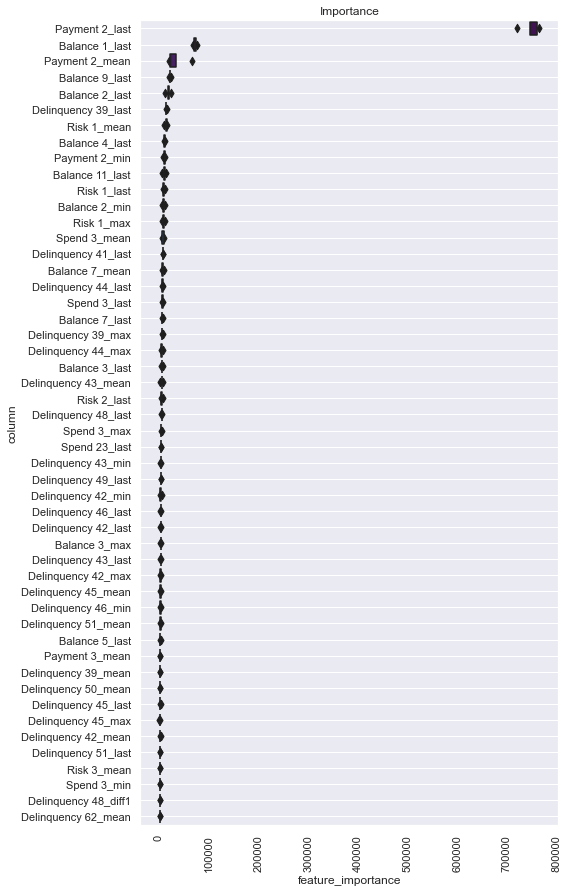

In [76]:
# 重要度の可視化
%matplotlib inline
fig, ax = visualize_importance(models, X_train)

In [77]:
models

[LGBMClassifier(colsample_samples=10, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
                subsample_freq=3),
 LGBMClassifier(colsample_samples=10, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
                subsample_freq=3),
 LGBMClassifier(colsample_samples=10, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
                subsample_freq=3),
 LGBMClassifier(colsample_samples=10, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_la

### 訓練データとテストデータでの予測結果の傾向差を見る
テストデータではどのような予測結果が出されるのか可視化してみる。\
今回のデータは訓練データとテストデータでユーザー特性が大きく異なることはあまりないと考えられる。\
なので訓練データとテストデータをもとにした予測結果もある程度は近くなると予測される。

In [68]:
# サンプルサブミットファイル
samp_sub = read_csv('sample_submission')

Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/data/sample_submission.csv


In [78]:
# K 個のモデルの予測確率（predict_proba） を作成する。 shape = (k, N_test, n_classes) になるはず。
pred_prob = np.array([model.predict_proba(X_test) for model in models])
print(f"1. shape: {pred_prob.shape}")

# k 個のモデルの平均を計算
pred_prob = np.mean(pred_prob, axis=0) # axis=0 なので shape の `k` が潰れる
print(f"2. shape: {pred_prob.shape}")


# 欲しいのは y=1 の確率なので全要素の 1 次元目を取っておく
pred_prob = pred_prob[:, 1]
print(f'3. shape: {pred_prob.shape}')

# ついでにsample_submissionのshapeとも比較する
print('4. shape:', samp_sub.shape)

1. shape: (5, 924621, 2)
2. shape: (924621, 2)
3. shape: (924621,)
4. shape: (924621, 2)


どういったラベルが予測されているか、などの傾向を知っておく。\
また学習時とテスト時で出力の乖離が無いか、を見ることも大事。乖離が大きい場合には、入力する値自体が大きく異なっているなどで性能悪化が起こっている可能性があるのでサブミットする前に注意する。

/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


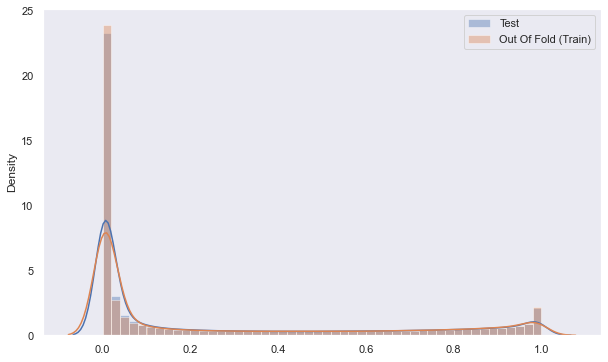

In [79]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(pred_prob, ax=ax, label="Test")
sns.distplot(oof, ax=ax, label="Out Of Fold (Train)")

ax.legend()
ax.grid()

#### NOTE: テストでの乖離が大きい とは
テストの予測値の乖離が大きい場合の原因はいくつか考えられますが「テスト時に使えない情報を特徴量としてつかっていないか?」を最も警戒した方が良いらしい。

テスト時に使えない特徴 A を利用してモデルを作っていると、学習時に A をみるようなモデルが出来る可能性があり、テスト時にそれを参照できないことで予測が上手く行かない場合がある。

もっとも極端なのは A が予測ラベルそのものである場合で、学習時は予測ラベルを参照できるため、それこそ精度100%で予測できるようなモデルができるが、テスト時には当然予測ラベルはわからないため、精度は大きく悪化する。このように予測ラベルの情報が学習時の特徴量に染み出してしまった結果学習が上手く行かないことをリークとよぶ（今回は予測対象が `TARGET` と分かりやすいので大丈夫だと思う）。

テストでの乖離が起こるのはリークの場合だけではないが、あまりに大きく異なる場合にはリークを含め、特徴量の選定に問題がないかを検討する。

## サブミットファイル作成

In [ ]:
# サンプルサブミットファイルの読み込み
sample_sub = pd.read_csv('../input/amexdata/sample_submission.csv')

In [85]:
samp_sub2 = samp_sub.copy()
samp_sub2.prediction = pred_prob
samp_sub2.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.0393
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.0015
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.0353
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.2488
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.9130


In [86]:
samp_sub2.to_csv(os.path.join(OUTPUT_DIR, 'submission_#1.csv'), index=False)